In [ ]:
#Импорт библиотек
import pandas as pd

import numpy as np

import tensorflow as tf

import pandas as pd

from tensorflow.keras.models import Sequential, Model

from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, MaxPooling1D

from tensorflow.keras import utils

from tensorflow.keras.optimizers import Adam, Adadelta, Adagrad, RMSprop

from tensorflow.keras.preprocessing.text import Tokenizer

from keras.callbacks import  ReduceLROnPlateau,  EarlyStopping , ModelCheckpoint

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error, mean_absolute_error

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
#Загружаем датасет с переменную
dt_wearout = pd.read_excel('/content/РЖД.xlsx', sheet_name='Износ')
dt_wearout.head(10)

,Н_Ло,Н_КП,Н_Се,Номер,Секция,Н_серии,Начало,Конец,Период,Износ,Толщина гребня на начало,Толщина гребня на конец,Пробег за период,Пробег на начало,Пробег на конец
0,4573,81329,18728,2,1,253,2022-01-25,2022-12-08,317,3.00,32.00,29.00,133132.0,1873288.0,2006420.0
1,4573,114993,18728,2,1,253,2022-01-25,2022-12-08,317,3.00,32.00,29.00,133132.0,1873288.0,2006420.0
2,4573,82697,18728,2,1,253,2022-01-25,2022-07-04,160,1.20,31.25,30.05,66482.0,1873288.0,1939770.0
3,4573,82697,18728,2,1,253,2022-07-05,2022-12-08,156,2.00,31.50,29.50,66650.0,1939770.0,2006420.0
4,4573,117134,18728,2,1,253,2022-01-25,2022-07-04,160,0.50,31.00,30.50,66482.0,1873288.0,1939770.0
5,4573,117134,18728,2,1,253,2022-07-05,2022-12-08,156,3.50,31.50,28.00,66650.0,1939770.0,2006420.0
6,4573,117376,23439,2,2,253,2022-01-25,2022-11-10,289,1.50,30.75,29.25,120438.0,1873288.0,1993726.0
7,4573,117376,23439,2,2,253,2022-11-11,2022-12-08,27,0.00,29.25,29.25,12694.0,1993726.0,2006420.0
8,4573,81104,23439,2,2,253,2022-01-25,2022-11-10,289,1.75,31.25,29.50,120438.0,1873288.0,1993726.0
9,4573,81104,23439,2,2,253,2022-11-11,2022-12-08,27,0.00,30.75,30.75,12694.0,1993726.0,2006420.0


In [ ]:
# удалим пропуски датасета Износ
dt_wearout = dt_wearout.dropna().reset_index(drop=True)
dt_wearout = dt_wearout[dt_wearout['Износ']<10]
# заменим данные столбца "Пробег за период" на значение разницы столбцов 'Пробег на конец' и 'Пробег на начало'
dt_wearout['Пробег за период'] = dt_wearout['Пробег на конец'] - dt_wearout['Пробег на начало']

In [ ]:
dt_wearout.drop(['Н_Ло', 'Н_КП', 'Н_Се', 'Номер', 'Начало',
                                  'Конец', 'Толщина гребня на начало',
                                  'Толщина гребня на конец', 'Пробег на начало',
                                  'Пробег на конец'], axis=1)

,Секция,Н_серии,Период,Износ,Пробег за период
0,1,253,317,3.00,133132.0
1,1,253,317,3.00,133132.0
2,1,253,160,1.20,66482.0
3,1,253,156,2.00,66650.0
4,1,253,160,0.50,66482.0
...,...,...,...,...,...
82280,2,222,82,1.00,40319.0
82281,2,222,80,0.50,40657.0
82282,2,222,82,1.00,40319.0
82283,2,222,80,1.25,40657.0


In [ ]:
# построим матрицу корреляции
dt_wearout.drop(['Н_Ло', 'Н_КП', 'Н_Се', 'Номер', 'Начало',
                                  'Конец', 'Толщина гребня на начало',
                                  'Толщина гребня на конец', 'Пробег на начало',
                                  'Пробег на конец'], axis=1).corr().style.background_gradient(cmap='coolwarm')

,Секция,Н_серии,Период,Износ,Пробег за период
Секция,1.000000,-0.110575,0.000994,0.039188,0.057922
Н_серии,-0.110575,1.000000,-0.012746,0.015267,-0.157611
Период,0.000994,-0.012746,1.000000,0.527819,0.910826
Износ,0.039188,0.015267,0.527819,1.000000,0.555292
Пробег за период,0.057922,-0.157611,0.910826,0.555292,1.000000


In [ ]:
# преобразуем категориальные данные и построим матрицу корреляции
pd.get_dummies(dt_wearout.drop(['Н_Ло', 'Н_КП', 'Н_Се', 'Номер', 'Начало',
                                  'Конец', 'Толщина гребня на начало',
                                  'Толщина гребня на конец', 'Пробег на начало',
                                  'Пробег на конец'], axis=1), columns=['Секция',	'Н_серии'])

,Период,Износ,Пробег за период,Секция_1,Секция_2,Секция_3,Н_серии_222,Н_серии_253,Н_серии_640
0,317,3.00,133132.0,1,0,0,0,1,0
1,317,3.00,133132.0,1,0,0,0,1,0
2,160,1.20,66482.0,1,0,0,0,1,0
3,156,2.00,66650.0,1,0,0,0,1,0
4,160,0.50,66482.0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...
82280,82,1.00,40319.0,0,1,0,1,0,0
82281,80,0.50,40657.0,0,1,0,1,0,0
82282,82,1.00,40319.0,0,1,0,1,0,0
82283,80,1.25,40657.0,0,1,0,1,0,0


In [ ]:
pd.get_dummies(dt_wearout.drop(['Н_Ло', 'Н_КП', 'Н_Се', 'Номер', 'Начало',
                                  'Конец', 'Толщина гребня на начало',
                                  'Толщина гребня на конец', 'Пробег на начало',
                                  'Пробег на конец'], axis=1), columns=['Секция',	'Н_серии']).corr().style.background_gradient(cmap='coolwarm')

,Период,Износ,Пробег за период,Секция_1,Секция_2,Секция_3,Н_серии_222,Н_серии_253,Н_серии_640
Период,1.000000,0.527819,0.910826,-0.002681,0.003946,-0.001753,0.006636,0.002908,-0.012584
Износ,0.527819,1.000000,0.555292,-0.017558,-0.020830,0.053322,-0.124123,0.119539,0.002877
Пробег за период,0.910826,0.555292,1.000000,-0.029124,-0.024439,0.074406,-0.040718,0.165978,-0.168490
Секция_1,-0.002681,-0.017558,-0.029124,1.000000,-0.740870,-0.360748,0.116811,-0.165169,0.067695
Секция_2,0.003946,-0.020830,-0.024439,-0.740870,1.000000,-0.359155,0.122998,-0.170353,0.066517
Секция_3,-0.001753,0.053322,0.074406,-0.360748,-0.359155,1.000000,-0.333110,0.466064,-0.186430
Н_серии_222,0.006636,-0.124123,-0.040718,0.116811,0.122998,-0.333110,1.000000,-0.714731,-0.355108
Н_серии_253,0.002908,0.119539,0.165978,-0.165169,-0.170353,0.466064,-0.714731,1.000000,-0.400010
Н_серии_640,-0.012584,0.002877,-0.168490,0.067695,0.066517,-0.186430,-0.355108,-0.400010,1.000000


In [ ]:
# выведем новое представление закодированной категориальной части
pd.get_dummies(dt_wearout.drop(['Н_Ло', 'Н_КП', 'Н_Се', 'Номер', 'Начало',
                                'Конец', 'Толщина гребня на начало',
                                'Толщина гребня на конец', 'Пробег на начало',
                                'Пробег на конец'], axis=1), columns=\
                                ['Секция',	'Н_серии']).drop(['Период','Износ',
                                                              'Пробег за период'],
                                                             axis=1).values.astype(int)

array([[1, 0, 0, 0, 1, 0],
       [1, 0, 0, 0, 1, 0],
       [1, 0, 0, 0, 1, 0],
       ...,
       [0, 1, 0, 1, 0, 0],
       [0, 1, 0, 1, 0, 0],
       [0, 1, 0, 1, 0, 0]])

In [ ]:
# создадим функция оценки результатов и вывода оценки

def eval_net(model, x_train, y_train, y_scaler = None, n = 10, limit = 10.):

    pred = model.predict(x_train)             # Предсказание на тренировочной выборке
    if y_scaler:                              # Если есть нормирование - то денормировать
        pred = y_scaler.inverse_transform(pred)

    print('Средняя абсолютная ошибка:', mean_absolute_error(pred, y_train), '\n')

    for i in range(n):
        print('Реальное значение: {:6.2f}  Предсказанное значение: {:6.2f}  Разница: {:6.2f}'.format(y_train[i, 0],
                                                                                                    pred[i, 0],
                                                                                                    abs(y_train[i, 0] - pred[i, 0])))
    # Построение картинки разброса предсказанных и верных значений зарплаты
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(y_train, pred)                 # Отрисовка точечного графика
    ax.set_xlim(0, limit)                     # Пределы по x, y
    ax.set_ylim(0, limit)
    ax.plot(plt.xlim(), plt.ylim(), 'r')      # Отрисовка диагональной линии
    plt.xlabel('Правильные значения Износа')
    plt.ylabel('Предсказания')
    plt.grid()
    plt.show()

In [ ]:
# создадим функцию для вывода графиков средней абсолютной ошибки на обучающем и проверочном наборе
def plot_history(history):
    plt.plot(history.history['mae'],
            label='Средняя абсолютная ошибка на обучающем наборе')
    plt.plot(history.history['val_mae'],
            label='Средняя абсолютная ошибка на проверочном наборе')
    plt.xlabel('Эпоха обучения')
    plt.ylabel('Средняя абсолютная ошибка')
    plt.legend()
    plt.show()

In [ ]:
# Визуальная оценка ошибки на обучающей и проверочной выборках

def compare_sharp_loss (history, x_size=6, y_size=4):

  # Смотрим графики точности на обучающей и проверочной выборках
  plt.figure(figsize=(x_size,y_size))
  plt.plot(history.history['loss'],
         label='Ошибка на обучающей выборке')

  # Выводим график точности на проверочной выборке
  plt.plot(history.history['val_loss'],
         label='Ошибка проверочном наборе')
  plt.xlabel('Эпоха обучения')
  plt.ylabel('Средняя ошибка c callback')
  plt.legend()
  plt.show()

In [ ]:
# создадим выборки данных
x_data_num = pd.get_dummies(dt_wearout.drop(['Н_Ло', 'Н_КП', 'Н_Се', 'Номер', 'Начало',
                                  'Конец', 'Толщина гребня на начало',
                                  'Толщина гребня на конец', 'Пробег на начало',
                                  'Пробег на конец'], axis=1), columns=\
                                   ['Секция','Н_серии'])[['Период',
                                                          'Пробег за период']].values
x_data_cat = pd.get_dummies(dt_wearout.drop(['Н_Ло', 'Н_КП', 'Н_Се', 'Номер', 'Начало',
                                'Конец', 'Толщина гребня на начало',
                                'Толщина гребня на конец', 'Пробег на начало',
                                'Пробег на конец'], axis=1), columns=\
                                ['Секция',	'Н_серии']).drop(['Период','Износ',
                                                              'Пробег за период'],
                                                             axis=1).values.astype(int)
y_data = pd.get_dummies(dt_wearout.drop(['Н_Ло', 'Н_КП', 'Н_Се', 'Номер', 'Начало',
                                  'Конец', 'Толщина гребня на начало',
                                  'Толщина гребня на конец', 'Пробег на начало',
                                  'Пробег на конец'], axis=1), columns=\
                                   ['Секция',	'Н_серии'])['Износ'].values

In [ ]:
# выведем размер выборок
print(x_data_num.shape)
print(x_data_cat.shape)
print(y_data.shape)

(82284, 2)
(82284, 6)
(82284,)


# Числовые данные

In [ ]:
# нормируем числовые данные
x_scaler = StandardScaler()
x_num_scaled = x_scaler.fit_transform(x_data_num)

y_scaler = StandardScaler()
y_scaled = y_data.reshape(-1,1)
y_scaled = y_scaler.fit_transform(y_scaled)

print('Размер нормализованных числовых данных обучающей выборки', x_num_scaled.shape)
print('Размер нормализованных правильных ответов', y_scaled.shape)

Размер нормализованных числовых данных обучающей выборки (82284, 2)
Размер нормализованных правильных ответов (82284, 1)


In [ ]:
# разобъем числовую выборку на обучающую и тестовую
x_train_num, x_test_num, y_train_num, y_test_num = train_test_split(x_num_scaled,y_scaled,test_size=0.2,shuffle = False)
print(x_train_num.shape)
print(y_train_num.shape)
print(x_test_num.shape)
print(y_test_num.shape)

(65827, 2)
(65827, 1)
(16457, 2)
(16457, 1)


In [ ]:
# импортируем коллбэки
from keras.callbacks import  ReduceLROnPlateau,  EarlyStopping, ModelCheckpoint

earlystop=EarlyStopping(monitor='val_loss',
                        min_delta=0,
                        patience=4,
                        verbose=1,
                        baseline=None,
                        restore_best_weights=True)

reduceLROnPlateau = ReduceLROnPlateau(monitor='val_loss',
                                      factor=0.6,
                                      patience=2,
                                      verbose=1)

model_Checkpoint = ModelCheckpoint(filepath='/content/Модели/model.h5',
                                   monitor='val_loss',
                                   verbose=1,
                                   save_best_only=True,
                                   mode='auto',
                                   baseline=None)

Epoch 1/30
212/219 [============================>.] - ETA: 0s - loss: 0.7220 - mae: 0.6630
Epoch 1: val_loss improved from inf to 0.54062, saving model to /content/Модели/model.h5
219/219 [==============================] - 3s 5ms/step - loss: 0.7211 - mae: 0.6630 - val_loss: 0.5406 - val_mae: 0.5732 - lr: 0.0010
Epoch 2/30
 39/219 [====>.........................] - ETA: 0s - loss: 0.7200 - mae: 0.6608

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


214/219 [============================>.] - ETA: 0s - loss: 0.7069 - mae: 0.6559
Epoch 2: val_loss did not improve from 0.54062
219/219 [==============================] - 1s 5ms/step - loss: 0.7059 - mae: 0.6555 - val_loss: 0.5471 - val_mae: 0.5805 - lr: 0.0010
Epoch 3/30
215/219 [============================>.] - ETA: 0s - loss: 0.7074 - mae: 0.6563
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 3: val_loss did not improve from 0.54062
219/219 [==============================] - 1s 5ms/step - loss: 0.7067 - mae: 0.6562 - val_loss: 0.5561 - val_mae: 0.5786 - lr: 0.0010
Epoch 4/30
218/219 [============================>.] - ETA: 0s - loss: 0.7009 - mae: 0.6536
Epoch 4: val_loss did not improve from 0.54062
219/219 [==============================] - 1s 7ms/step - loss: 0.7005 - mae: 0.6534 - val_loss: 0.5624 - val_mae: 0.5850 - lr: 6.0000e-04
Epoch 5/30
215/219 [============================>.] - ETA: 0s - loss: 0.7007 - mae: 0.6539Restoring model weights 

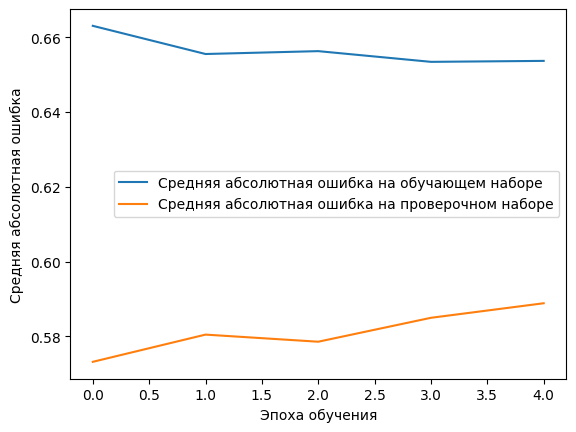

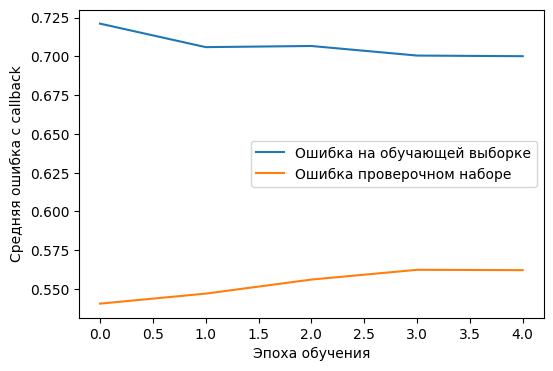

In [ ]:
# Обучение модели на числовых данных

model_num = Sequential()
model_num.add(BatchNormalization(input_dim=x_train_num.shape[1]))
model_num.add(Dense(128, activation='relu'))
model_num.add(Dense(1000, activation='relu'))
model_num.add(Dropout(0.2))
model_num.add(Dense(100, activation='relu'))
model_num.add(Dense(1, activation='linear'))

model_num.compile(optimizer=Adam(learning_rate=1e-3), loss='mse', metrics=['mae'])

history_num = model_num.fit(x_train_num,
                    y_train_num,
                    epochs=30,
                    batch_size=256,
                    validation_split=0.15,
                    verbose=1,
                    callbacks=[earlystop, reduceLROnPlateau, model_Checkpoint])

plot_history(history_num)
compare_sharp_loss(history_num)

2058/2058 [==============================] - 4s 2ms/step
Средняя абсолютная ошибка: 1.8073159262923573 

Реальное значение:   0.89  Предсказанное значение:   2.48  Разница:   1.59
Реальное значение:   0.89  Предсказанное значение:   2.48  Разница:   1.59
Реальное значение:  -0.44  Предсказанное значение:   2.36  Разница:   2.80
Реальное значение:   0.15  Предсказанное значение:   2.29  Разница:   2.14
Реальное значение:  -0.96  Предсказанное значение:   2.36  Разница:   3.32
Реальное значение:   1.26  Предсказанное значение:   2.29  Разница:   1.04
Реальное значение:  -0.22  Предсказанное значение:   2.49  Разница:   2.71
Реальное значение:  -1.32  Предсказанное значение:   0.56  Разница:   1.89
Реальное значение:  -0.03  Предсказанное значение:   2.49  Разница:   2.52
Реальное значение:  -1.32  Предсказанное значение:   0.56  Разница:   1.89


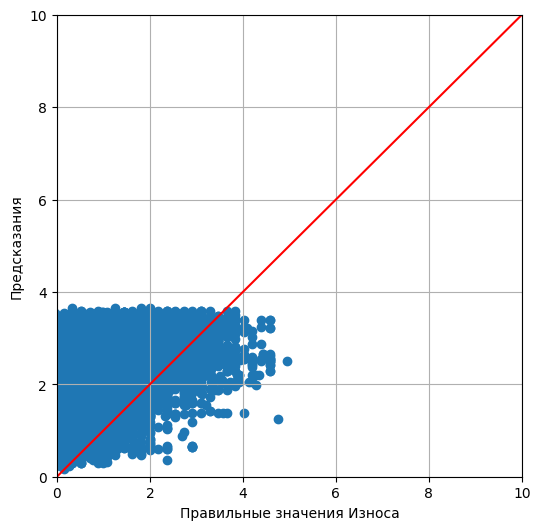

In [ ]:
eval_net(model_num, x_train_num, y_train_num, y_scaler)

# Категориальные данные

In [ ]:
# разобъем категориальную выборку на обучающую и тестовую
x_train_cat, x_test_cat, y_train_cat, y_test_cat = train_test_split(x_data_cat,y_scaled,test_size=0.2,shuffle = False)
print(x_train_cat.shape)
print(y_train_cat.shape)
print(x_test_cat.shape)
print(y_test_cat.shape)

(65827, 6)
(65827, 1)
(16457, 6)
(16457, 1)


Epoch 1/30
210/219 [===========================>..] - ETA: 0s - loss: 1.0859 - mae: 0.8459
Epoch 1: val_loss did not improve from 0.54062
219/219 [==============================] - 3s 5ms/step - loss: 1.0860 - mae: 0.8457 - val_loss: 0.7810 - val_mae: 0.7255 - lr: 1.0000e-04
Epoch 2/30
218/219 [============================>.] - ETA: 0s - loss: 1.0849 - mae: 0.8459
Epoch 2: val_loss did not improve from 0.54062
219/219 [==============================] - 1s 5ms/step - loss: 1.0851 - mae: 0.8459 - val_loss: 0.7696 - val_mae: 0.7168 - lr: 1.0000e-04
Epoch 3/30
218/219 [============================>.] - ETA: 0s - loss: 1.0847 - mae: 0.8458
Epoch 3: val_loss did not improve from 0.54062
219/219 [==============================] - 1s 5ms/step - loss: 1.0844 - mae: 0.8457 - val_loss: 0.7657 - val_mae: 0.7140 - lr: 1.0000e-04
Epoch 4/30
215/219 [============================>.] - ETA: 0s - loss: 1.0837 - mae: 0.8454
Epoch 4: val_loss did not improve from 0.54062
219/219 [=========================

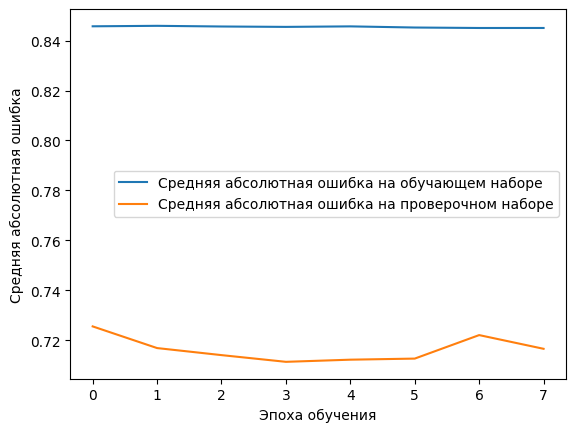

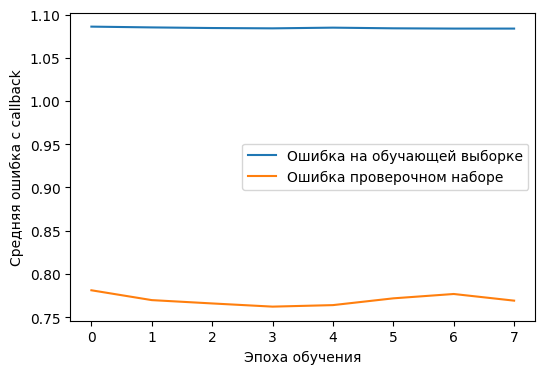

In [ ]:
# Обучение модели на категориальных данных

model_cat = Sequential()
model_cat.add(BatchNormalization(input_dim=x_train_cat.shape[1]))
model_cat.add(Dense(128, activation='relu'))
model_cat.add(Dense(1000, activation='relu'))
model_cat.add(Dense(100, activation='relu'))
model_cat.add(Dense(1, activation='linear'))

model_cat.compile(optimizer=Adam(learning_rate=1e-4), loss='mse', metrics=['mae'])

history_cat = model_cat.fit(x_train_cat,
                    y_train_cat,
                    epochs=30,
                    batch_size=256,
                    validation_split=0.15,
                    verbose=1,
                    callbacks=[earlystop, reduceLROnPlateau, model_Checkpoint])

plot_history(history_cat)
compare_sharp_loss(history_cat)

2058/2058 [==============================] - 4s 2ms/step
Средняя абсолютная ошибка: 1.8799171135699488 

Реальное значение:   0.89  Предсказанное значение:   1.95  Разница:   1.06
Реальное значение:   0.89  Предсказанное значение:   1.95  Разница:   1.06
Реальное значение:  -0.44  Предсказанное значение:   1.95  Разница:   2.39
Реальное значение:   0.15  Предсказанное значение:   1.95  Разница:   1.80
Реальное значение:  -0.96  Предсказанное значение:   1.95  Разница:   2.90
Реальное значение:   1.26  Предсказанное значение:   1.95  Разница:   0.69
Реальное значение:  -0.22  Предсказанное значение:   1.95  Разница:   2.17
Реальное значение:  -1.32  Предсказанное значение:   1.95  Разница:   3.27
Реальное значение:  -0.03  Предсказанное значение:   1.95  Разница:   1.98
Реальное значение:  -1.32  Предсказанное значение:   1.95  Разница:   3.27


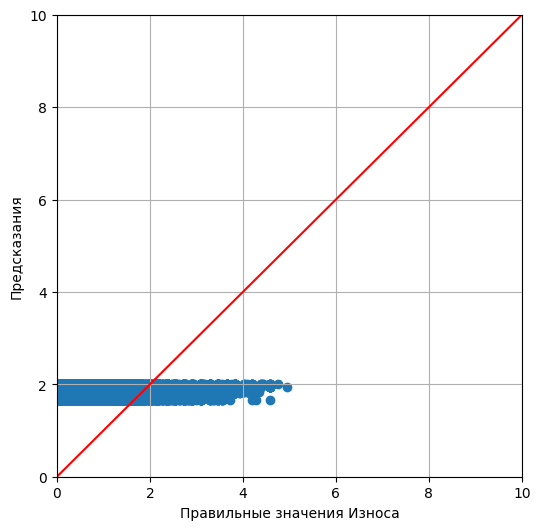

In [ ]:
eval_net(model_cat, x_train_cat, y_train_cat, y_scaler)

# FunctionalAPI

In [ ]:
# построим FunctionalAPI

input1 = Input((x_train_num.shape[1],))
input2 = Input((x_train_cat.shape[1],))

x1 = input1                               # Ветка числовых данных
x1 = Dense(128, activation="relu")(x1)
x1 = Dense(1000, activation="elu")(x1)
x1 = Dropout(0.3)(x1)
x1 = Dense(100, activation="relu")(x1)

x2 = input2                               # Ветка категориальных данных
x2 = Dense(20, activation="relu")(x2)
x2 = Dense(500, activation="tanh")(x2)
x2 = Dropout(0.3)(x2)

x = concatenate([x1, x2])             # Объединение веток

x = Dense(15, activation='relu')(x)       # Промежуточный слой
x = Dropout(0.5)(x)
x = Dense(1, activation='linear')(x)      # Финальный регрессирующий нейрон

# В Model передаются входы и выход
model_func = Model((input1, input2), x)

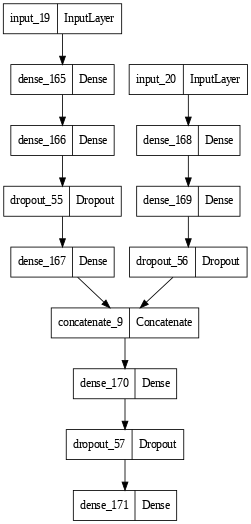

In [ ]:
# выведем схему построения модели
utils.plot_model(model_func, dpi=60)

In [ ]:
model_func.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_19 (InputLayer)       [(None, 2)]                  0         []                            
                                                                                                  
 dense_165 (Dense)           (None, 128)                  384       ['input_19[0][0]']            
                                                                                                  
 input_20 (InputLayer)       [(None, 6)]                  0         []                            
                                                                                                  
 dense_166 (Dense)           (None, 1000)                 129000    ['dense_165[0][0]']           
                                                                                            

Epoch 1/50
269/274 [============================>.] - ETA: 0s - loss: 0.7288 - mae: 0.6699
Epoch 1: val_loss improved from 0.54062 to 0.52926, saving model to /content/Модели/model.h5
274/274 [==============================] - 4s 9ms/step - loss: 0.7291 - mae: 0.6700 - val_loss: 0.5293 - val_mae: 0.5707 - lr: 0.0010
Epoch 2/50
 17/274 [>.............................] - ETA: 1s - loss: 0.6993 - mae: 0.6545

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


264/274 [===========================>..] - ETA: 0s - loss: 0.7127 - mae: 0.6615
Epoch 2: val_loss did not improve from 0.52926
274/274 [==============================] - 2s 7ms/step - loss: 0.7129 - mae: 0.6615 - val_loss: 0.5316 - val_mae: 0.5709 - lr: 0.0010
Epoch 3/50
273/274 [============================>.] - ETA: 0s - loss: 0.7084 - mae: 0.6604
Epoch 3: val_loss improved from 0.52926 to 0.52393, saving model to /content/Модели/model.h5
274/274 [==============================] - 2s 6ms/step - loss: 0.7084 - mae: 0.6604 - val_loss: 0.5239 - val_mae: 0.5701 - lr: 0.0010
Epoch 4/50
269/274 [============================>.] - ETA: 0s - loss: 0.7064 - mae: 0.6595
Epoch 4: val_loss improved from 0.52393 to 0.52321, saving model to /content/Модели/model.h5
274/274 [==============================] - 1s 5ms/step - loss: 0.7063 - mae: 0.6595 - val_loss: 0.5232 - val_mae: 0.5688 - lr: 0.0010
Epoch 5/50
267/274 [============================>.] - ETA: 0s - loss: 0.7033 - mae: 0.6575
Epoch 5: val

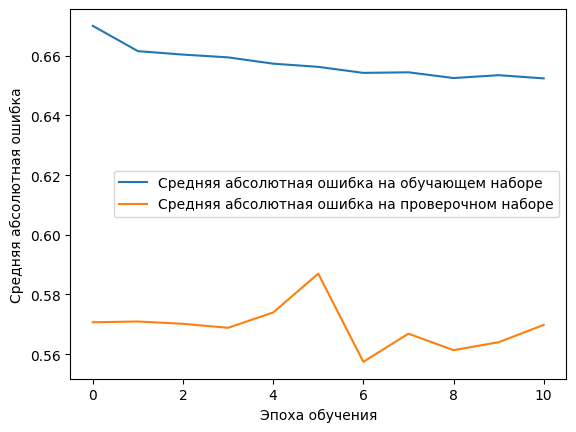

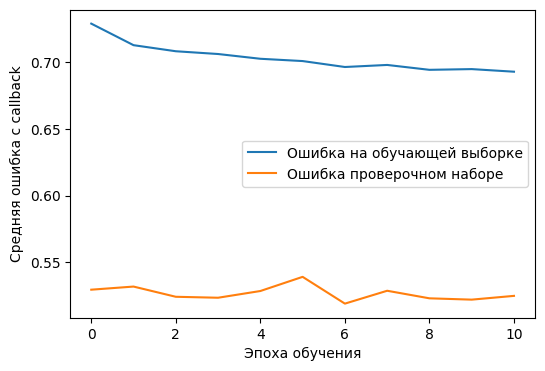

In [ ]:
model_func.compile(optimizer=Adam(learning_rate=1e-3), loss='mse', metrics=['mae'])

history_func = model_func.fit([x_num_scaled, x_data_cat],
                           y_scaled,
                           batch_size=256,
                           epochs=50,
                           validation_split=0.15,
                           verbose=1,
                           callbacks=[earlystop, reduceLROnPlateau, model_Checkpoint])
plot_history(history_func)
compare_sharp_loss(history_func)

2572/2572 [==============================] - 5s 2ms/step
Средняя абсолютная ошибка: 0.8403407745475983 

Реальное значение:   3.00  Предсказанное значение:   2.71  Разница:   0.29
Реальное значение:   3.00  Предсказанное значение:   2.71  Разница:   0.29
Реальное значение:   1.20  Предсказанное значение:   2.26  Разница:   1.06
Реальное значение:   2.00  Предсказанное значение:   2.20  Разница:   0.20
Реальное значение:   0.50  Предсказанное значение:   2.26  Разница:   1.76
Реальное значение:   3.50  Предсказанное значение:   2.20  Разница:   1.30
Реальное значение:   1.50  Предсказанное значение:   2.73  Разница:   1.23
Реальное значение:   0.00  Предсказанное значение:   0.81  Разница:   0.81
Реальное значение:   1.75  Предсказанное значение:   2.73  Разница:   0.98
Реальное значение:   0.00  Предсказанное значение:   0.81  Разница:   0.81


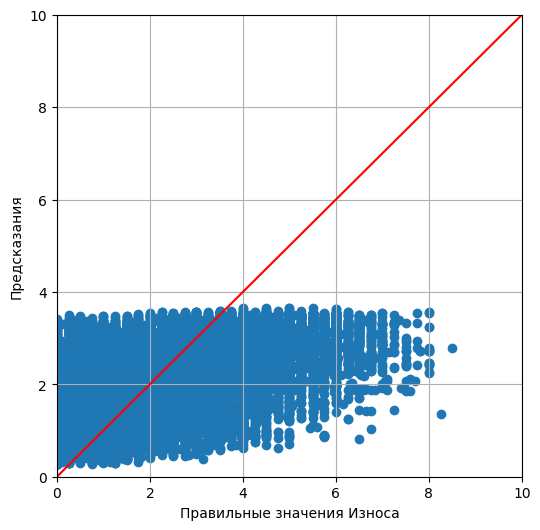

In [ ]:
eval_net(model_func, [x_num_scaled, x_data_cat], y_data.reshape(-1,1), y_scaler)

## Подбор гиперпараметров

In [ ]:
# построим новую модель FunctionalAPI

input1 = Input((x_train_num.shape[1],))
input2 = Input((x_train_cat.shape[1],))

x1_1 = input1                               # Ветка числовых данных
x1_1 = Dense(100, activation='sigmoid')(x1_1)
x1_1 = Dense(1000, activation='sigmoid')(x1_1)
x1_1 = Dropout(0.3)(x1_1)
x1_1 = Dense(2000, activation='sigmoid')(x1_1)
x1_1 = Dropout(0.2)(x1_1)
x1_1 = Dense(2000, activation='sigmoid')(x1_1)
x1_1 = Dense(2000, activation='sigmoid')(x1_1)
x1_1 = Dense(2000, activation='sigmoid')(x1_1)
x1_1 = Dense(2000, activation='sigmoid')(x1_1)
x1_1 = Dropout(0.3)(x1_1)
x1_1 = Dense(1, activation='linear')(x1_1)

x2_1 = input2                               # Ветка категориальных данных
x2_1 = Dense(150, activation='sigmoid')(x2_1)
x2_1 = Dense(650, activation="tanh")(x2_1)
x2_1 = Dropout(0.2)(x2_1)
x2_1 = Dense(1000, activation='sigmoid')(x2_1)
x2_1 = Dense(500, activation="tanh")(x2_1)
x2_1 = Dropout(0.3)(x2_1)

x_1 = concatenate([x1_1, x2_1])             # Объединение веток

x_1 = Dense(150, activation='sigmoid')(x_1)       # Промежуточный слой
x_1 = Dense(1000, activation='sigmoid')(x_1)
x_1 = Dropout(0.4)(x_1)
x_1 = Dense(650, activation='sigmoid')(x_1)
x_1 = Dense(1, activation='linear')(x_1)      # Финальный регрессирующий нейрон

# В Model передаются входы и выход
model_func_1 = Model((input1, input2), x_1)

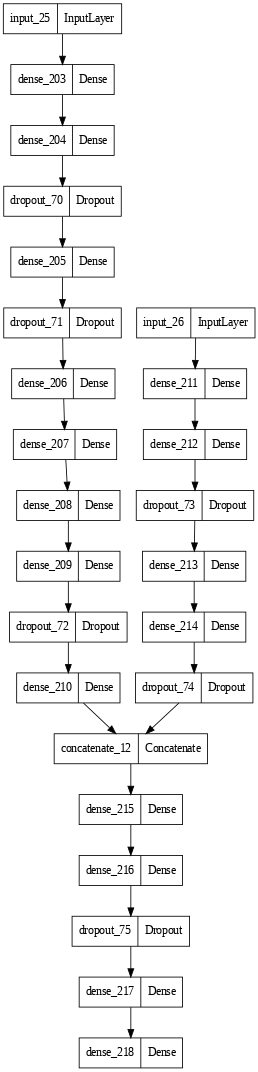

In [ ]:
# выведем схему построения модели
utils.plot_model(model_func_1, dpi=60)

In [ ]:
model_func_1.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_25 (InputLayer)       [(None, 2)]                  0         []                            
                                                                                                  
 dense_203 (Dense)           (None, 100)                  300       ['input_25[0][0]']            
                                                                                                  
 dense_204 (Dense)           (None, 1000)                 101000    ['dense_203[0][0]']           
                                                                                                  
 dropout_70 (Dropout)        (None, 1000)                 0         ['dense_204[0][0]']           
                                                                                           

Epoch 1/50
513/515 [============================>.] - ETA: 0s - loss: 1.0734 - mae: 0.8386
Epoch 1: val_loss did not improve from 0.51879
515/515 [==============================] - 11s 14ms/step - loss: 1.0731 - mae: 0.8385 - val_loss: 0.8340 - val_mae: 0.7555 - lr: 1.0000e-04
Epoch 2/50
515/515 [==============================] - ETA: 0s - loss: 1.0637 - mae: 0.8357
Epoch 2: val_loss did not improve from 0.51879
515/515 [==============================] - 7s 14ms/step - loss: 1.0637 - mae: 0.8357 - val_loss: 0.8001 - val_mae: 0.7311 - lr: 1.0000e-04
Epoch 3/50
512/515 [============================>.] - ETA: 0s - loss: 1.0556 - mae: 0.8321
Epoch 3: val_loss did not improve from 0.51879
515/515 [==============================] - 7s 13ms/step - loss: 1.0557 - mae: 0.8320 - val_loss: 0.7777 - val_mae: 0.7142 - lr: 1.0000e-04
Epoch 4/50
513/515 [============================>.] - ETA: 0s - loss: 1.0513 - mae: 0.8309
Epoch 4: val_loss did not improve from 0.51879
515/515 [=====================

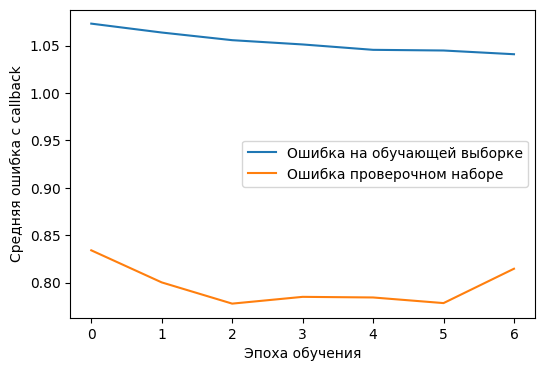

In [ ]:
model_func_1.compile(optimizer=Adam(learning_rate=1e-4), loss='mse', metrics=['mae'])

history_func_1 = model_func_1.fit([x_num_scaled, x_data_cat],
                           y_scaled,
                           batch_size=128,
                           epochs=50,
                           validation_split=0.2,
                           verbose=1,
                           callbacks=[earlystop, reduceLROnPlateau, model_Checkpoint])

compare_sharp_loss(history_func_1)

2572/2572 [==============================] - 7s 3ms/step
Средняя абсолютная ошибка: 1.0859149838023558 

Реальное значение:   3.00  Предсказанное значение:   1.68  Разница:   1.32
Реальное значение:   3.00  Предсказанное значение:   1.68  Разница:   1.32
Реальное значение:   1.20  Предсказанное значение:   1.68  Разница:   0.48
Реальное значение:   2.00  Предсказанное значение:   1.68  Разница:   0.32
Реальное значение:   0.50  Предсказанное значение:   1.68  Разница:   1.18
Реальное значение:   3.50  Предсказанное значение:   1.68  Разница:   1.82
Реальное значение:   1.50  Предсказанное значение:   1.68  Разница:   0.18
Реальное значение:   0.00  Предсказанное значение:   1.68  Разница:   1.68
Реальное значение:   1.75  Предсказанное значение:   1.68  Разница:   0.07
Реальное значение:   0.00  Предсказанное значение:   1.68  Разница:   1.68


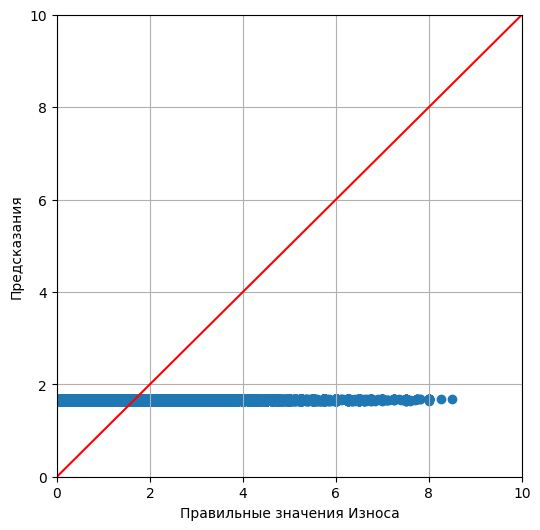

In [ ]:
eval_net(model_func_1, [x_num_scaled, x_data_cat], y_data.reshape(-1,1), y_scaler)